# Tutorial 

**NB: This notebook requires matplotlib**

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib widget

In [2]:
os.environ["MITHRA_DATA"] = "../data/"
from mithra import *
import mithra.utils as utils
print(utils.dirs["data"])

/Users/nichollsh/Projects/MITHRA/data


In [3]:
import importlib
importlib.reload(spec)
importlib.reload(tracks)

<module 'mithra.tracks' from '/Users/nichollsh/Projects/MITHRA/src/mithra/tracks.py'>

## Read and plot evolution tracks

In [4]:
# Reads Baraffe+15 evolution tracks from txt file in data folder
tr = tracks.read_bhac()

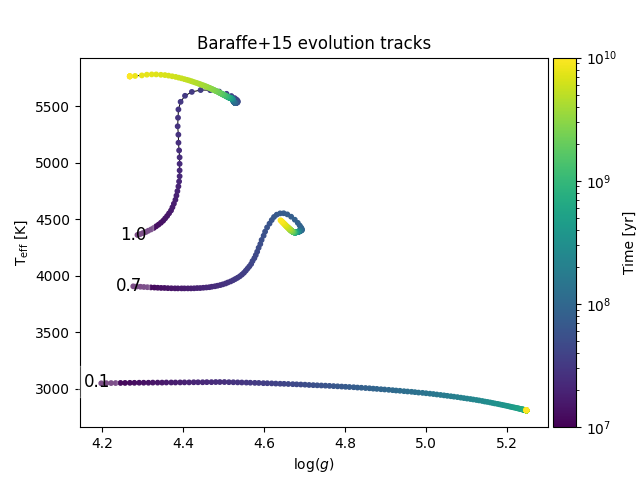

In [5]:
# Timestamps
times = np.logspace(7,10,200)
cmap= plt.cm.viridis
norm = mpl.colors.LogNorm(vmin=times[0], vmax=times[-1]) 
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)    
sm.set_array([])  

# Setup plot
plt.close("all")
fig,ax = plt.subplots(1,1)

# For each mass...
masses = [0.1, 0.7, 1.0]
styles = ["dotted", "dashed", "solid"]
for i in range(len(masses)):
    teffs = []
    loggs = []
    mass = masses[i]
    for age in times:  # For each time, get Teff and logg
        vals = tracks.get_params_bhac(tr, mass, age, ["Teff","logg"])
        teffs.append(vals[0])
        loggs.append(vals[1])
    # Make plot for this mass
    ax.plot(loggs, teffs, color='k', lw=0.7, linestyle=styles[i])
    ax.scatter(loggs, teffs, c=times, cmap=cmap, norm=norm, s=10, zorder=3)
    ax.text(loggs[0]*0.99, teffs[0]*0.99, "%.1f"%mass, backgroundcolor=(1.0, 1.0, 1.0, 0.3), fontsize=12)

# Colourbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(sm, cax=cax, orientation='vertical', label='Time [yr]')  

# Show plot
ax.set(xlabel="log($g$)", ylabel=r"T$_{\text{eff}}$ [K]", title="Baraffe+15 evolution tracks")
plt.show()

## Get stellar spectrum for a particular mass, age

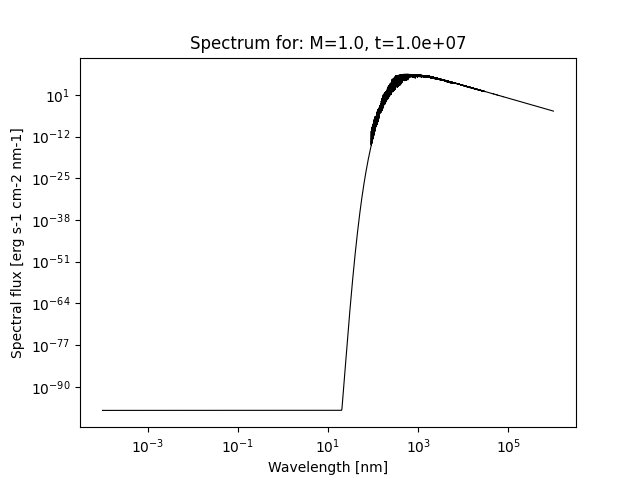

In [7]:
mass = 1.0
age  = 1.0e7

# Get Teff and logg for this stellar mass and age
out = tracks.get_params_bhac(tr, mass, age, ["Teff","logg"])

# Crudely get closest spectrum for this Teff and logg
wl, fl = spec.get_spec_from_npy(out[0], out[1])

# Make plot of spectrum for this time
fig,ax = plt.subplots()
ax.plot(wl,fl, lw=0.8, color='black')
ax.set(xscale="log", yscale="log")
ax.set(xlabel="Wavelength [nm]", ylabel="Spectral flux [erg s-1 cm-2 nm-1]", title="Spectrum for: M=%.1f, t=%.1e"%(mass, age))
plt.show()    

# Save data
spec.write_tsv(os.path.join(utils.dirs["output"],"spec.csv"), wl, fl)

## Create a low-resolution interpolated grid 

The interpolated grid has dimensions of `(num_teff, num_logg, num_wave)`. This becomes increasingly expensive with increasing `num_wave` but the choice of the other two parameters does not impact performance. This is because larger values of `num_wave` require including extra data in order to perform the interpolation.

In [8]:
itp = spec.create_interp(num_teff=40, num_logg=40, num_wave=30, teff_lims=(5e3, 6e3))

Reading npy files...
    done
Source axes: (teff, logg, wave) = (11, 7, 30)
Interpolation target: (teff, logg, wave) = (40, 40, 30)
Meshgrid
Interpolating...
    please wait
    done


In [9]:
# Check shape of interpolated data
v,x,y,z = itp[0],itp[1],itp[2],itp[3]
sh = np.shape(v)
print(sh)

(40, 40, 30)


It is possible to store these interpolated points in an Xarray dataset. This can then be saved to (and read from) a single NetCDF file

In [10]:
# Convert to xarray dataset from interpolated values and save to a NetCDF file
ds = spec.create_dataset(itp)
spec.write_dataset(ds, os.path.join(utils.dirs["output"],"tutorial.nc"))

## Check interpolation for a Sun-like case

Target: 5780.0 4.438
Close: 5769.2307692307695 4.423076923076923


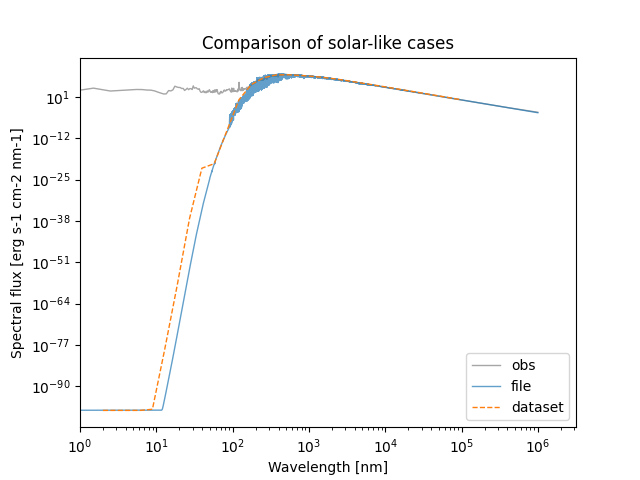

In [17]:
# Target Teff and logg for this point
target_teff = 5780.0
target_logg = 4.438
print("Target:", target_teff, target_logg)

# Init plot
plt.close("all")
fig,ax = plt.subplots(1,1)

# Plot solar data
wl_so, fl_so = spec.read_tsv(os.path.join(utils.dirs["pkg"],"solar.tsv"))
ax.plot(wl_so,fl_so,label="obs", lw=1, color='grey', alpha=0.7)

# Plot from nearest npy file
wl_npy, fl_npy = spec.get_spec_from_npy(target_teff, target_logg)
ax.plot(wl_npy,fl_npy,label="file", lw=1, color='tab:blue', alpha=0.7)

# Plot from xarray dataset
wl_ds,fl_ds,teff,logg = spec.get_spec_from_dataset(ds, target_teff, target_logg)
ax.plot(wl_ds,fl_ds,label="dataset", lw=1, color='tab:orange' ,linestyle='dashed')
print("Close:", teff, logg)

# Show
ax.set(xscale="log",yscale="log", xlabel="Wavelength [nm]", ylabel="Spectral flux [erg s-1 cm-2 nm-1]")
ax.set_xlim(left=1.0)
ax.set_title("Comparison of solar-like cases")
ax.legend()
plt.show()

* The pink line shows the full spectrum from the grid. This includes narrow features.    
* The black line shows the interpolated spectrum, which broadly looks the same but does not contain as many features because of the reduced resolution of the data.     
* The orange line shows the same data as the black line, but is stored in a different format.

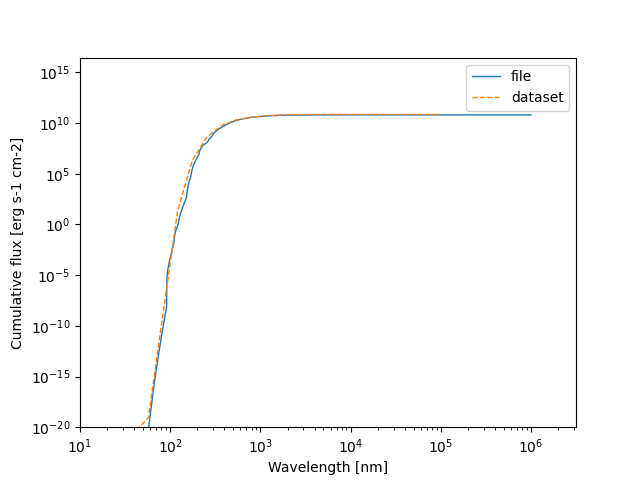

In [12]:
integ_npy = spec.integrate_spectrum(wl_npy, fl_npy)
integ_ds = spec.integrate_spectrum(wl_ds, fl_ds)

fig,ax = plt.subplots(1,1)

ax.plot(wl_npy, integ_npy,label="file", lw=1, color='tab:blue' )
ax.plot(wl_ds, integ_ds, label="dataset", lw=1, color='tab:orange' ,linestyle='dashed')

ax.set(xscale="log", xlabel="Wavelength [nm]", yscale="log", ylabel="Cumulative flux [erg s-1 cm-2]")
ax.set_ylim(bottom=1e-20)
ax.set_xlim(left=10)
ax.legend()
plt.show()

The plot above shows the cumulative (integrated) fluxes from the original high-resolution file (blue), and the interpolation (orange). We can see that they are similar.

## Plot spectral evolution for a fixed stellar mass

In [13]:
# Loading a medium resolution grid instead...
# ds_medium = spec.read_dataset(os.path.join(utils.dirs["pkg"],"interp_medium.nc"))

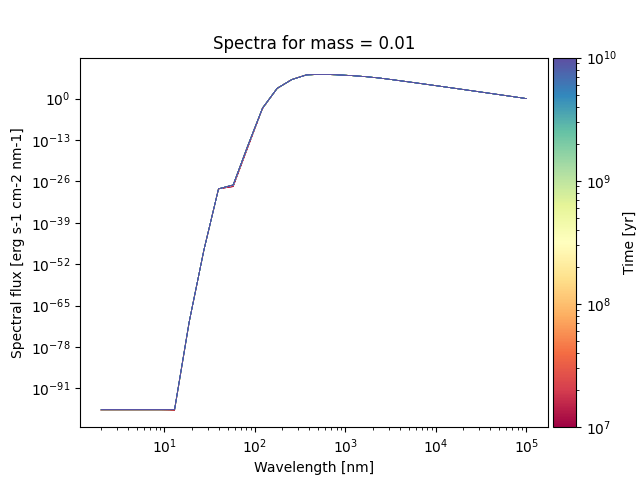

In [14]:
# Timestamps
tarr = np.logspace(7,10,50)

# Colourbar
cmap= plt.cm.Spectral
norm = mpl.colors.LogNorm(vmin=tarr[0], vmax=tarr[-1]) 
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)    
sm.set_array([])  

# Mass of star
mass = 0.01

# Init plot
fig,ax = plt.subplots(1,1)

# For each time...
for time in tarr:

    # Get Teff and logg
    out = tracks.get_params_bhac(tr, mass, time, ["Teff","logg","mass"])
    mass = out[2]
    c = cmap(norm(time))
    
    # Get spectrum from interpolated grid
    w,f,_,_ = spec.get_spec_from_dataset(ds,out[0],out[1])
    
    # Plot this spectrum
    ax.plot(w,f, color=c, alpha=1.0, lw=0.5, zorder=3)

# Show plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(sm, cax=cax, orientation='vertical', label='Time [yr]')  
ax.set(xscale="log", yscale="log")
ax.set(xlabel="Wavelength [nm]", ylabel="Spectral flux [erg s-1 cm-2 nm-1]")
ax.set_title("Spectra for mass = %.2f"%mass)
plt.show()